<a href="https://colab.research.google.com/github/mohamedssafini/deepLearning/blob/main/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data = pd.read_csv('train.csv')

In [4]:
test_data = pd.read_csv('test.csv')

In [ ]:
train_data

In [ ]:
test_data 

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [10]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [14]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Un

In [15]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [16]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.646073,-0.507197,1.046078,0.896679,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.523038,Gd,TA,PConc,Gd,TA,No,GLQ,0.580708,Unf,-0.29303,-0.934542,-0.444176,GasA,Ex,Y,SBrkr,-0.773728,1.207172,-0.10118,0.413476,1.086464,-0.249767,0.781232,1.232388,0.169898,-0.207663,Gd,0.986680,Typ,-0.924153,NaN,Attchd,0.973110,RFn,0.306423,0.348780,TA,TA,Y,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,-0.063174,2.187904,0.154737,-0.395536,Gable,CompShg,MetalSd,MetalSd,None,-0.569893,TA,TA,CBlock,Gd,TA,Gd,ALQ,1.177709,Unf,-0.29303,-0.629681,0.476948,GasA,Ex,Y,SBrkr,0.261030,-0.784891,-0.10118,-0.471810,-0.819258,3.820454,0.781232,-0.756191,0.169898,-0.207663,TA,-0.287709,Typ,0.623525,TA,Attchd,-0.082638,RFn,0.306423,-0.059772,TA,TA,Y,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.646073,-0.507197,0.980053,0.848819,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.333448,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.097840,Unf,-0.29303,-0.288418,-0.298974,GasA,Ex,Y,SBrkr,-0.610614,1.235163,-0.10118,0.563659,1.086464,-0.249767,0.781232,1.232388,0.169898,-0.207663,Gd,-0.287709,Typ,0.623525,TA,Attchd,0.894907,RFn,0.306423,0.627338,TA,TA,Y,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,0.646073,-0.507197,-1.859033,-0.682695,Gable,CompShg,Wd Sdng,Wd Shng,None,-0.569893,TA,TA,BrkTil,TA,Gd,No,ALQ,-0.494771,Unf,-0.29303,-0.047258,-0.671053,GasA,Gd,Y,SBrkr,-0.506118,0.978574,-0.10118,0.427309,1.086464,-0.249767,-1.027187,-0.756191,0.169898,-0.207663,Gd,0.349486,Typ,0.623525,Gd,Detchd,0.777601,Unf,1.619406,0.785188,TA,TA,Y,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,1.355319,-0.507197,0.947040,0.753100,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.381770,Gd,TA,PConc,Gd,TA,Av,GLQ,0.468770,Unf,-0.29303,-0.161013,0.211501,GasA,Ex,Y,SBrkr,-0.037164,1.671364,-0.10118,1.377806,1.086464,-0.249767,0.781232,1.232388,1.385418,-0.207663,Gd,1.623875,Typ,0.623525,TA,Attchd,0.855805,RFn,1.619406,1.685860,TA,TA,Y,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.069222,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,-1.481667,1.2895

In [19]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [20]:
all_features 

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PavedDrive_nan,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,-0.934542,-0.444176,-0.773728,1.207172,-0.10118,0.413476,1.086464,-0.249767,0.781232,1.232388,0.169898,-0.207663,0.986680,-0.924153,0.973110,0.306423,0.348780,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,-0.629681,0.476948,0.261030,-0.784891,-0.10118,-0.471810,-0.819258,3.820454,0.781232,-0.756191,0.169898,-0.207663,-0.287709,0.623525,-0.082638,0.306423,-0.059772,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,-0.288418,-0.298974,-0.610614,1.235163,-0.10118,0.563659,1.086464,-0.249767,0.781232,1.232388,0.169898,-0.207663,-0.287709,0.623525,0.894907,0.306423,0.627338,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,-0.047258,-0.671053,-0.506118,0.978574,-0.10118,0.427309,1.086464,-0.249767,-1.027187,-0.756191,0.169898,-0.207663,0.349486,0.623525,0.777601,1.619406,0.785188,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,-1.363335,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,-0.161013,0.211501,-0.037164,1.671364,-0.10118,1.377806,1.086464,-0.249767,0.781232,1.232388,1.385418,-0.207663,1.623875,0.623525,0.855805,1.619406,1.685860,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,2.131647,0.157619,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,-0.033608,-1.147496,-1.563815,0.488723,-0.10118,-0.807744,-0.819258,-0.249767,-1.027187,1.232388,0.169898,-0.207663,-0.924904,-0.924153,0.000000,-2.319544,-2.195385,-0.740634,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.078492,-1.363335,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1455,2.419

In [21]:
all_features.shape

(2919, 331)

In [23]:
import tensorflow as tf

In [25]:
n_train = train_data.shape[0]
train_features = tf.constant(all_features[:n_train].values, dtype=tf.float32)
test_features = tf.constant(all_features[n_train:].values, dtype=tf.float32)
train_labels = tf.constant(train_data.SalePrice.values.reshape(-1, 1),
                           dtype=tf.float32)

In [27]:
loss = tf.keras.losses.MeanSquaredError()

def get_net():
    net = tf.keras.models.Sequential()
    net.add(
        tf.keras.layers.Dense(
            1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    return net

In [28]:
def log_rmse(y_true, y_pred):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(
        tf.reduce_mean(loss(tf.math.log(y_true), tf.math.log(clipped_preds))))

In [29]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.compile(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat)
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
    return train_ls, test_ls

In [30]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [31]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.170237, valid log rmse 0.156974
fold 2, train log rmse 0.162174, valid log rmse 0.190798
fold 3, train log rmse 0.163624, valid log rmse 0.168214
fold 4, train log rmse 0.167808, valid log rmse 0.154725
fold 5, train log rmse 0.162971, valid log rmse 0.182570
5-fold validation: avg train log rmse: 0.165363, avg valid log rmse: 0.170656


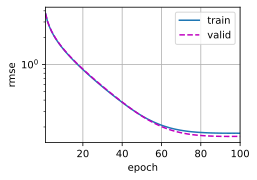

In [38]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [40]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162148


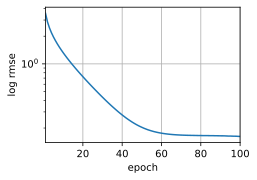

In [41]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [37]:
from d2l import tensorflow as d2l

In [36]:
!pip install d2l==0.16.6

     |████████████████████████████████| 92kB 4.0MB/s 
